In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, MinMaxScaler, RobustScaler

from sklearn.impute import SimpleImputer

from sklearn.compose import ColumnTransformer

from sklearn.model_selection import cross_val_score

from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

import optuna

from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

import random

import warnings
warnings.filterwarnings('ignore')

In [2]:

# Cargar el archivo df_train.parquet y df_test.parquet
train_dataset = pd.read_parquet('df_train.parquet')
test_dataset  = pd.read_parquet('df_test.parquet')

## 1: Comprensión y Preparación de los Datos

Objetivo: Obtener un entendimiento claro de los datos y realizar un preprocesamiento exhaustivo.

### 1.1: Análisis Exploratorio de Datos (EDA)

#### 1.1.1: Revisión del Conjunto de Datos

<class 'pandas.core.frame.DataFrame'>
Index: 23494 entries, 16484 to 9409
Data columns (total 46 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   MEDICAMENTOS                   23494 non-null  float64
 1   MEDICINA ESPECIALIZADA         23494 non-null  float64
 2   MEDICINA GENERAL               23494 non-null  float64
 3   Cant_gr_flia                   23494 non-null  int64  
 4   Cant_riesgos_flia_mean         23494 non-null  float64
 5   min_Tiempo_CP_Fliar            8 non-null      float64
 6   Cant_Fliar_CP                  23494 non-null  float64
 7   psa_max_gr_flia                164 non-null    float64
 8   psa_min_gr_flia                164 non-null    float64
 9   Cant_Fliar_riesgos             23494 non-null  float64
 10  cantidad_serv_flia             23494 non-null  float64
 11  Pendiente_flia                 23494 non-null  float64
 12  Intercepto_flia                23494 non-null  f

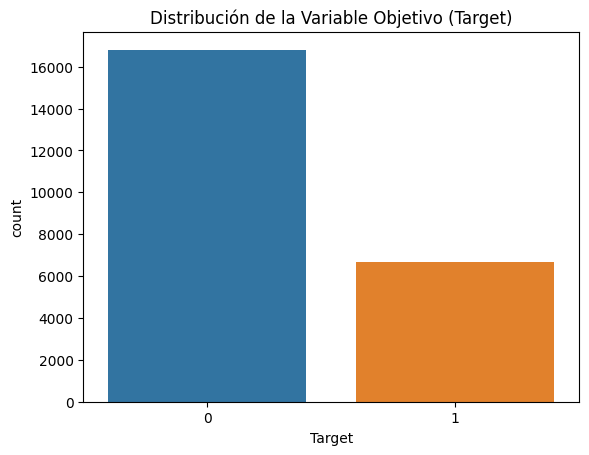

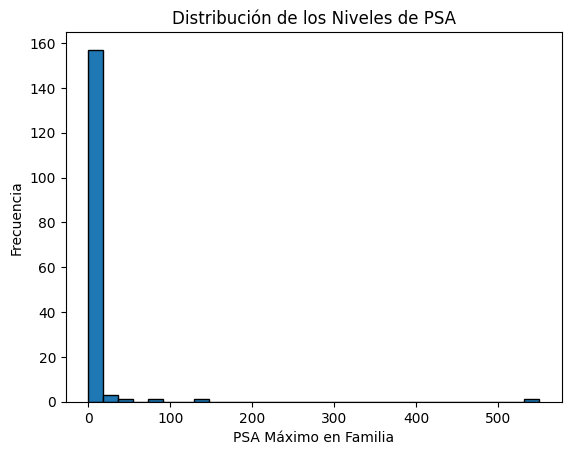

In [3]:
data_df = pd.read_parquet('df_train.parquet')

# Obtener información básica del dataset
print(data_df.info())  # Ver los tipos de datos y si hay valores nulos
print(data_df.describe())  # Estadísticas descriptivas de las variables numéricas
print(data_df.head())  # Primeras filas del dataset para familiarizarse con las columnas

# Visualizar la distribución de la variable objetivo "Target"
sns.countplot(x='Target', data=data_df)
plt.title('Distribución de la Variable Objetivo (Target)')
plt.show()

# Histograma de una variable importante como el PSA
plt.hist(data_df['psa_max_gr_flia'].dropna(), bins=30, edgecolor='black')
plt.title('Distribución de los Niveles de PSA')
plt.xlabel('PSA Máximo en Familia')
plt.ylabel('Frecuencia')
plt.show()

#### 1.1.2: Análisis del Baseline

Baseline ROC_AUC: 0.7819378741690961


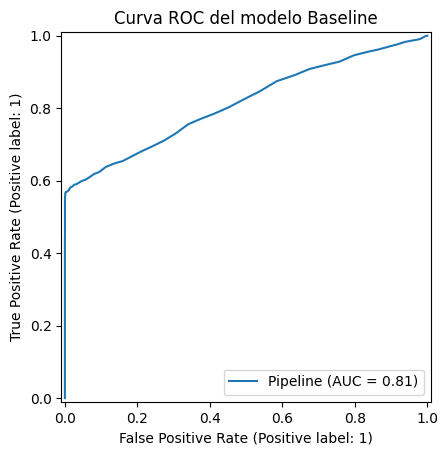

In [4]:
# Importar librerías necesarias
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

# Separar las variables predictoras y la variable objetivo
X = data_df.drop('Target', axis=1)  # Elimina la columna objetivo 'Target'
y = data_df['Target']  # Columna objetivo

# Identificar variables categóricas y numéricas
cat_features = X.select_dtypes(include=['object']).columns.tolist()  # Variables categóricas
num_features = X.select_dtypes(exclude=['object']).columns.tolist()  # Variables numéricas

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Crear un transformador para las variables numéricas y categóricas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), num_features),  # Imputación en numéricas
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)  # OneHotEncoding en categóricas
    ])

# Crear un pipeline con el preprocesador y un modelo de Random Forest
baseline_pipeline = Pipeline([
    ('preprocessor', preprocessor),  # Transformaciones en los datos
    ('model', RandomForestClassifier(random_state=42))  # Modelo Random Forest
])

# Entrenar el modelo con el pipeline
baseline_pipeline.fit(X_train, y_train)

# Predecir los resultados en el conjunto de prueba
y_pred = baseline_pipeline.predict(X_test)

# Evaluar el modelo con la métrica de ROC AUC
auc = roc_auc_score(y_test, y_pred)
print(f"Baseline ROC_AUC: {auc}")
# Graficar la curva ROC
RocCurveDisplay.from_estimator(baseline_pipeline, X_test, y_test)
plt.title('Curva ROC del modelo Baseline')
plt.show()

El modelo inicial que construimos tiene una capacidad del 78.19% para distinguir entre pacientes con niveles de PSA anormales y normales. Este es un buen punto de partida para nuestro análisis, ya que nos da una base sólida sobre la cual podemos trabajar. Aún así, sabemos que en el ámbito médico, donde la detección temprana es crítica, queremos reducir al mínimo el margen de error. Por eso, continuaremos optimizando el modelo para mejorar su precisión

### 1.2: Identificación de Problemas en los Datos

#### 1.2.1: Análisis de Valores Faltantes

Número de valores faltantes por columna:
min_Tiempo_CP_Fliar      23486
psa_max_gr_flia          23330
psa_min_gr_flia          23330
IMC                      10364
AGRUPACION_SISTOLICA      3320
AGRUPACION_DIASTOLICA     3320
RIESGOS                  16283
PERDIDA_DE_PESO          17723
CANCER_MAMA_FAMILIAR      6802
dtype: int64

Porcentaje de valores faltantes por columna:
min_Tiempo_CP_Fliar      99.965949
psa_max_gr_flia          99.301949
psa_min_gr_flia          99.301949
IMC                      44.113391
AGRUPACION_SISTOLICA     14.131268
AGRUPACION_DIASTOLICA    14.131268
RIESGOS                  69.307057
PERDIDA_DE_PESO          75.436282
CANCER_MAMA_FAMILIAR     28.952073
dtype: float64


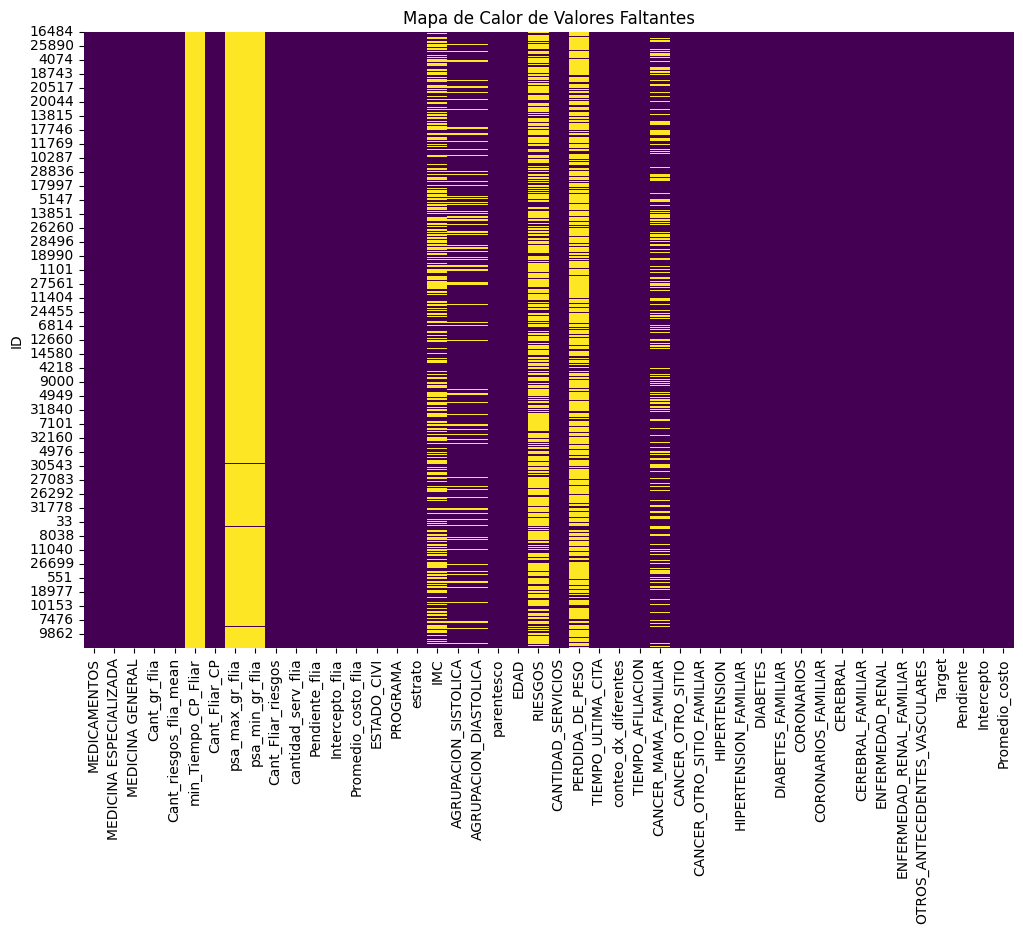

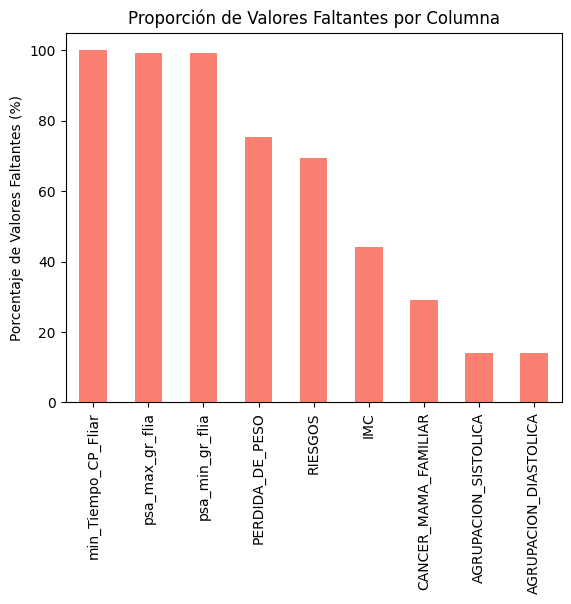

In [5]:
# Ver el número total de valores faltantes en cada columna
missing_values = data_df.isnull().sum()
print("Número de valores faltantes por columna:")
print(missing_values[missing_values > 0])  # Mostrar solo columnas con valores faltantes

# Mostrar la proporción de valores faltantes en porcentaje
missing_percentage = data_df.isnull().mean() * 100
print("\nPorcentaje de valores faltantes por columna:")
print(missing_percentage[missing_percentage > 0])  # Mostrar solo columnas con valores faltantes

# Visualización de valores faltantes con un heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(data_df.isnull(), cbar=False, cmap='viridis')
plt.title('Mapa de Calor de Valores Faltantes')
plt.show()

# Visualización de la proporción de valores faltantes con un gráfico de barras
missing_percentage[missing_percentage > 0].sort_values(ascending=False).plot(kind='bar', color='salmon')
plt.title('Proporción de Valores Faltantes por Columna')
plt.ylabel('Porcentaje de Valores Faltantes (%)')
plt.show()

1. Variables con una Alta Proporción de Valores Faltantes
- Las variables min_Tiempo_CP_Fliar, psa_max_gr_flia, psa_min_gr_flia y psa_gr_flia tienen un porcentaje de valores faltantes que se acerca o alcanza el 100%. Esto indica que prácticamente toda la información en estas columnas está ausente.
- Conclusión: Es probable que estas columnas no proporcionen suficiente información útil debido al alto porcentaje de valores faltantes. Estas se pueden considerar para eliminar del análisis, ya que imputar un porcentaje tan alto de valores faltantes podría introducir sesgos o no ser útil.

2. Variables con Valores Faltantes Moderados
- Variables como PERDIDA_DE_PESO, RIESGOS y IMC tienen entre un 40% y 60% de valores faltantes.
- Conclusión: Estas variables tienen una cantidad significativa de datos faltantes, pero aún pueden contener información valiosa. En este caso, podría ser viable aplicar técnicas de imputación para completar estos valores y mantener la información.

3. Variables con Bajos Valores Faltantes
- AGRUPACION_SISTOLICA, AGRUPACION_DIASTOLICA, y CANCER_MAMA_FAMILIAR tienen menos del 20% de valores faltantes.
- Conclusión: Para estas columnas, la imputación sería una buena solución, ya que tienen una cantidad manejable de datos faltantes y se puede completar sin distorsionar demasiado la distribución.

#### 1.2.2: Análisis de Outliers

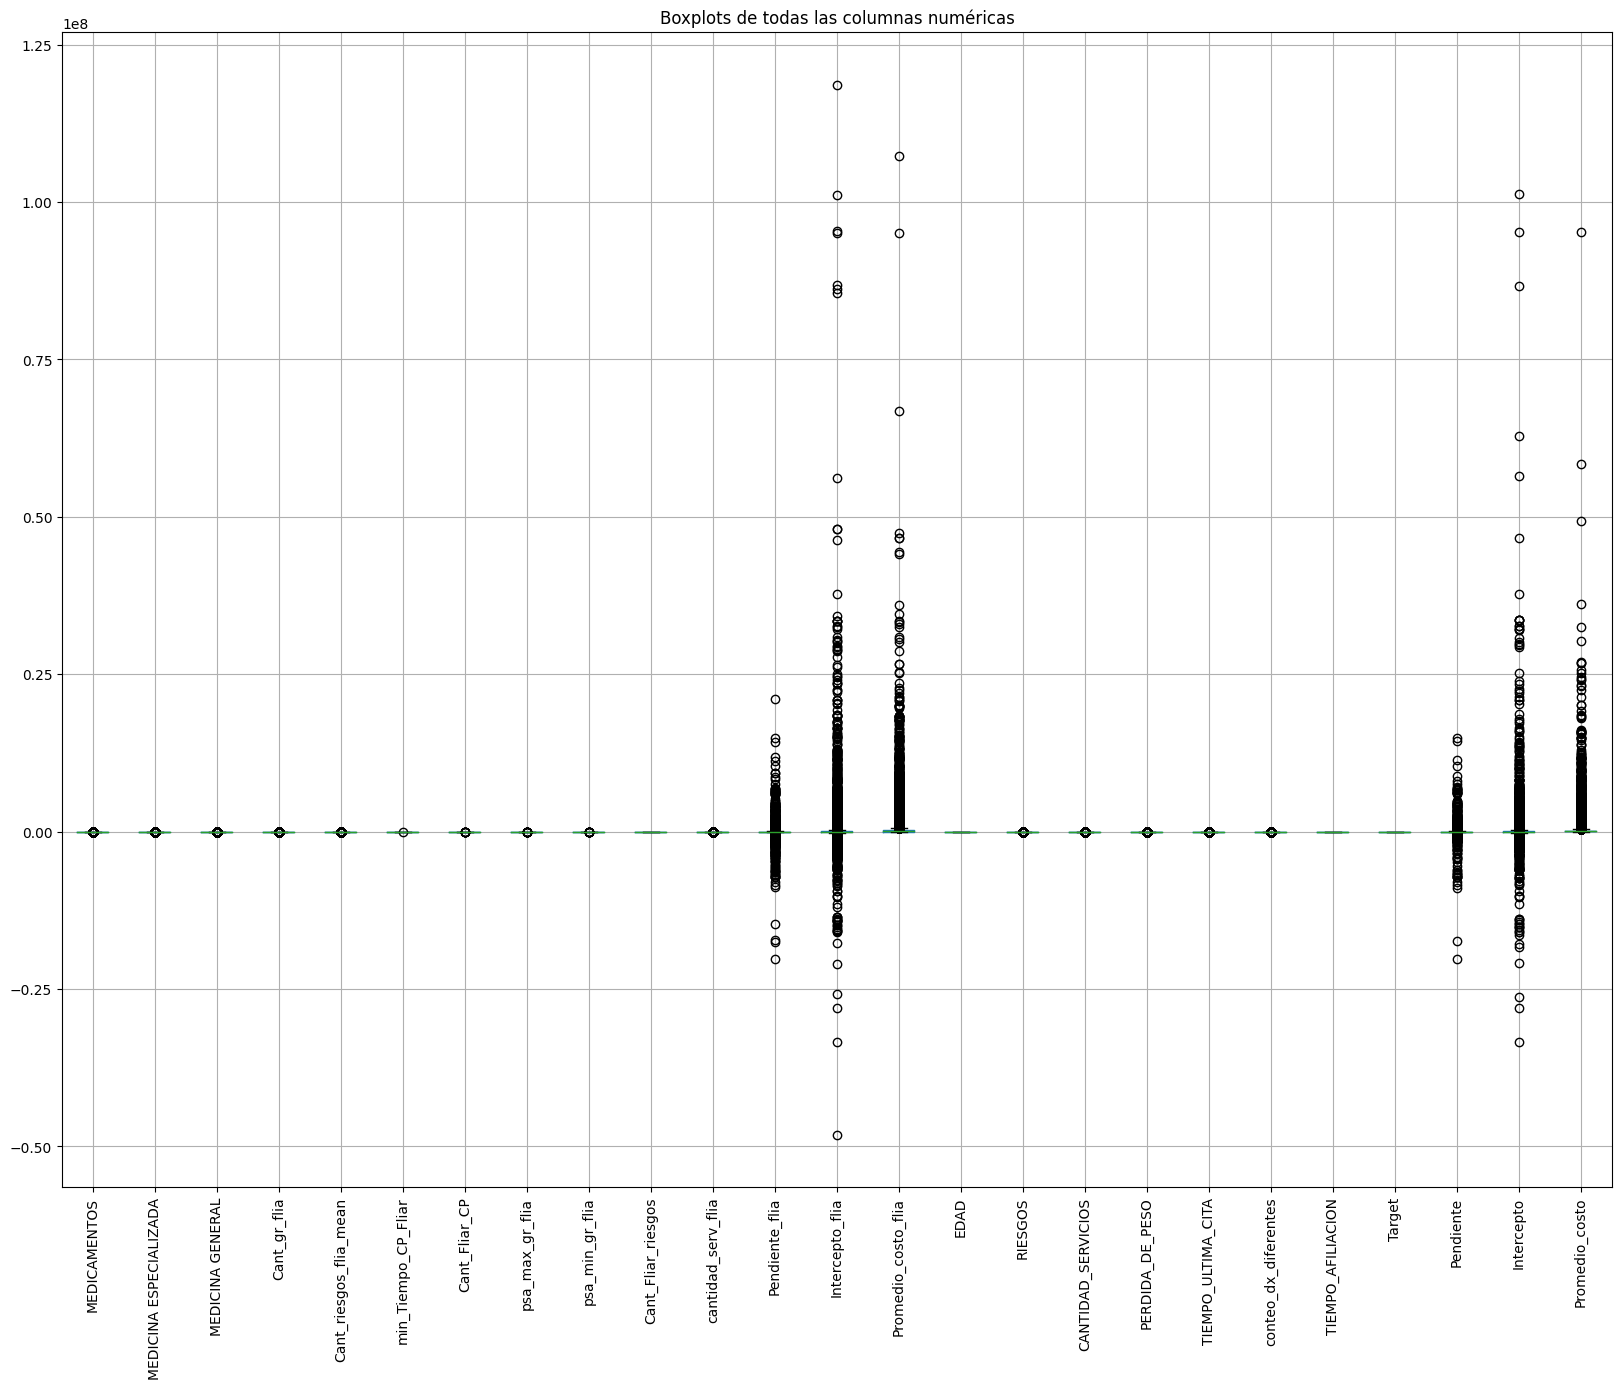

In [6]:
# Visualización de outliers usando boxplots para todas las columnas numéricas
plt.figure(figsize=(20, 15))
data_df.boxplot(rot=90)
plt.title('Boxplots de todas las columnas numéricas')
plt.show()

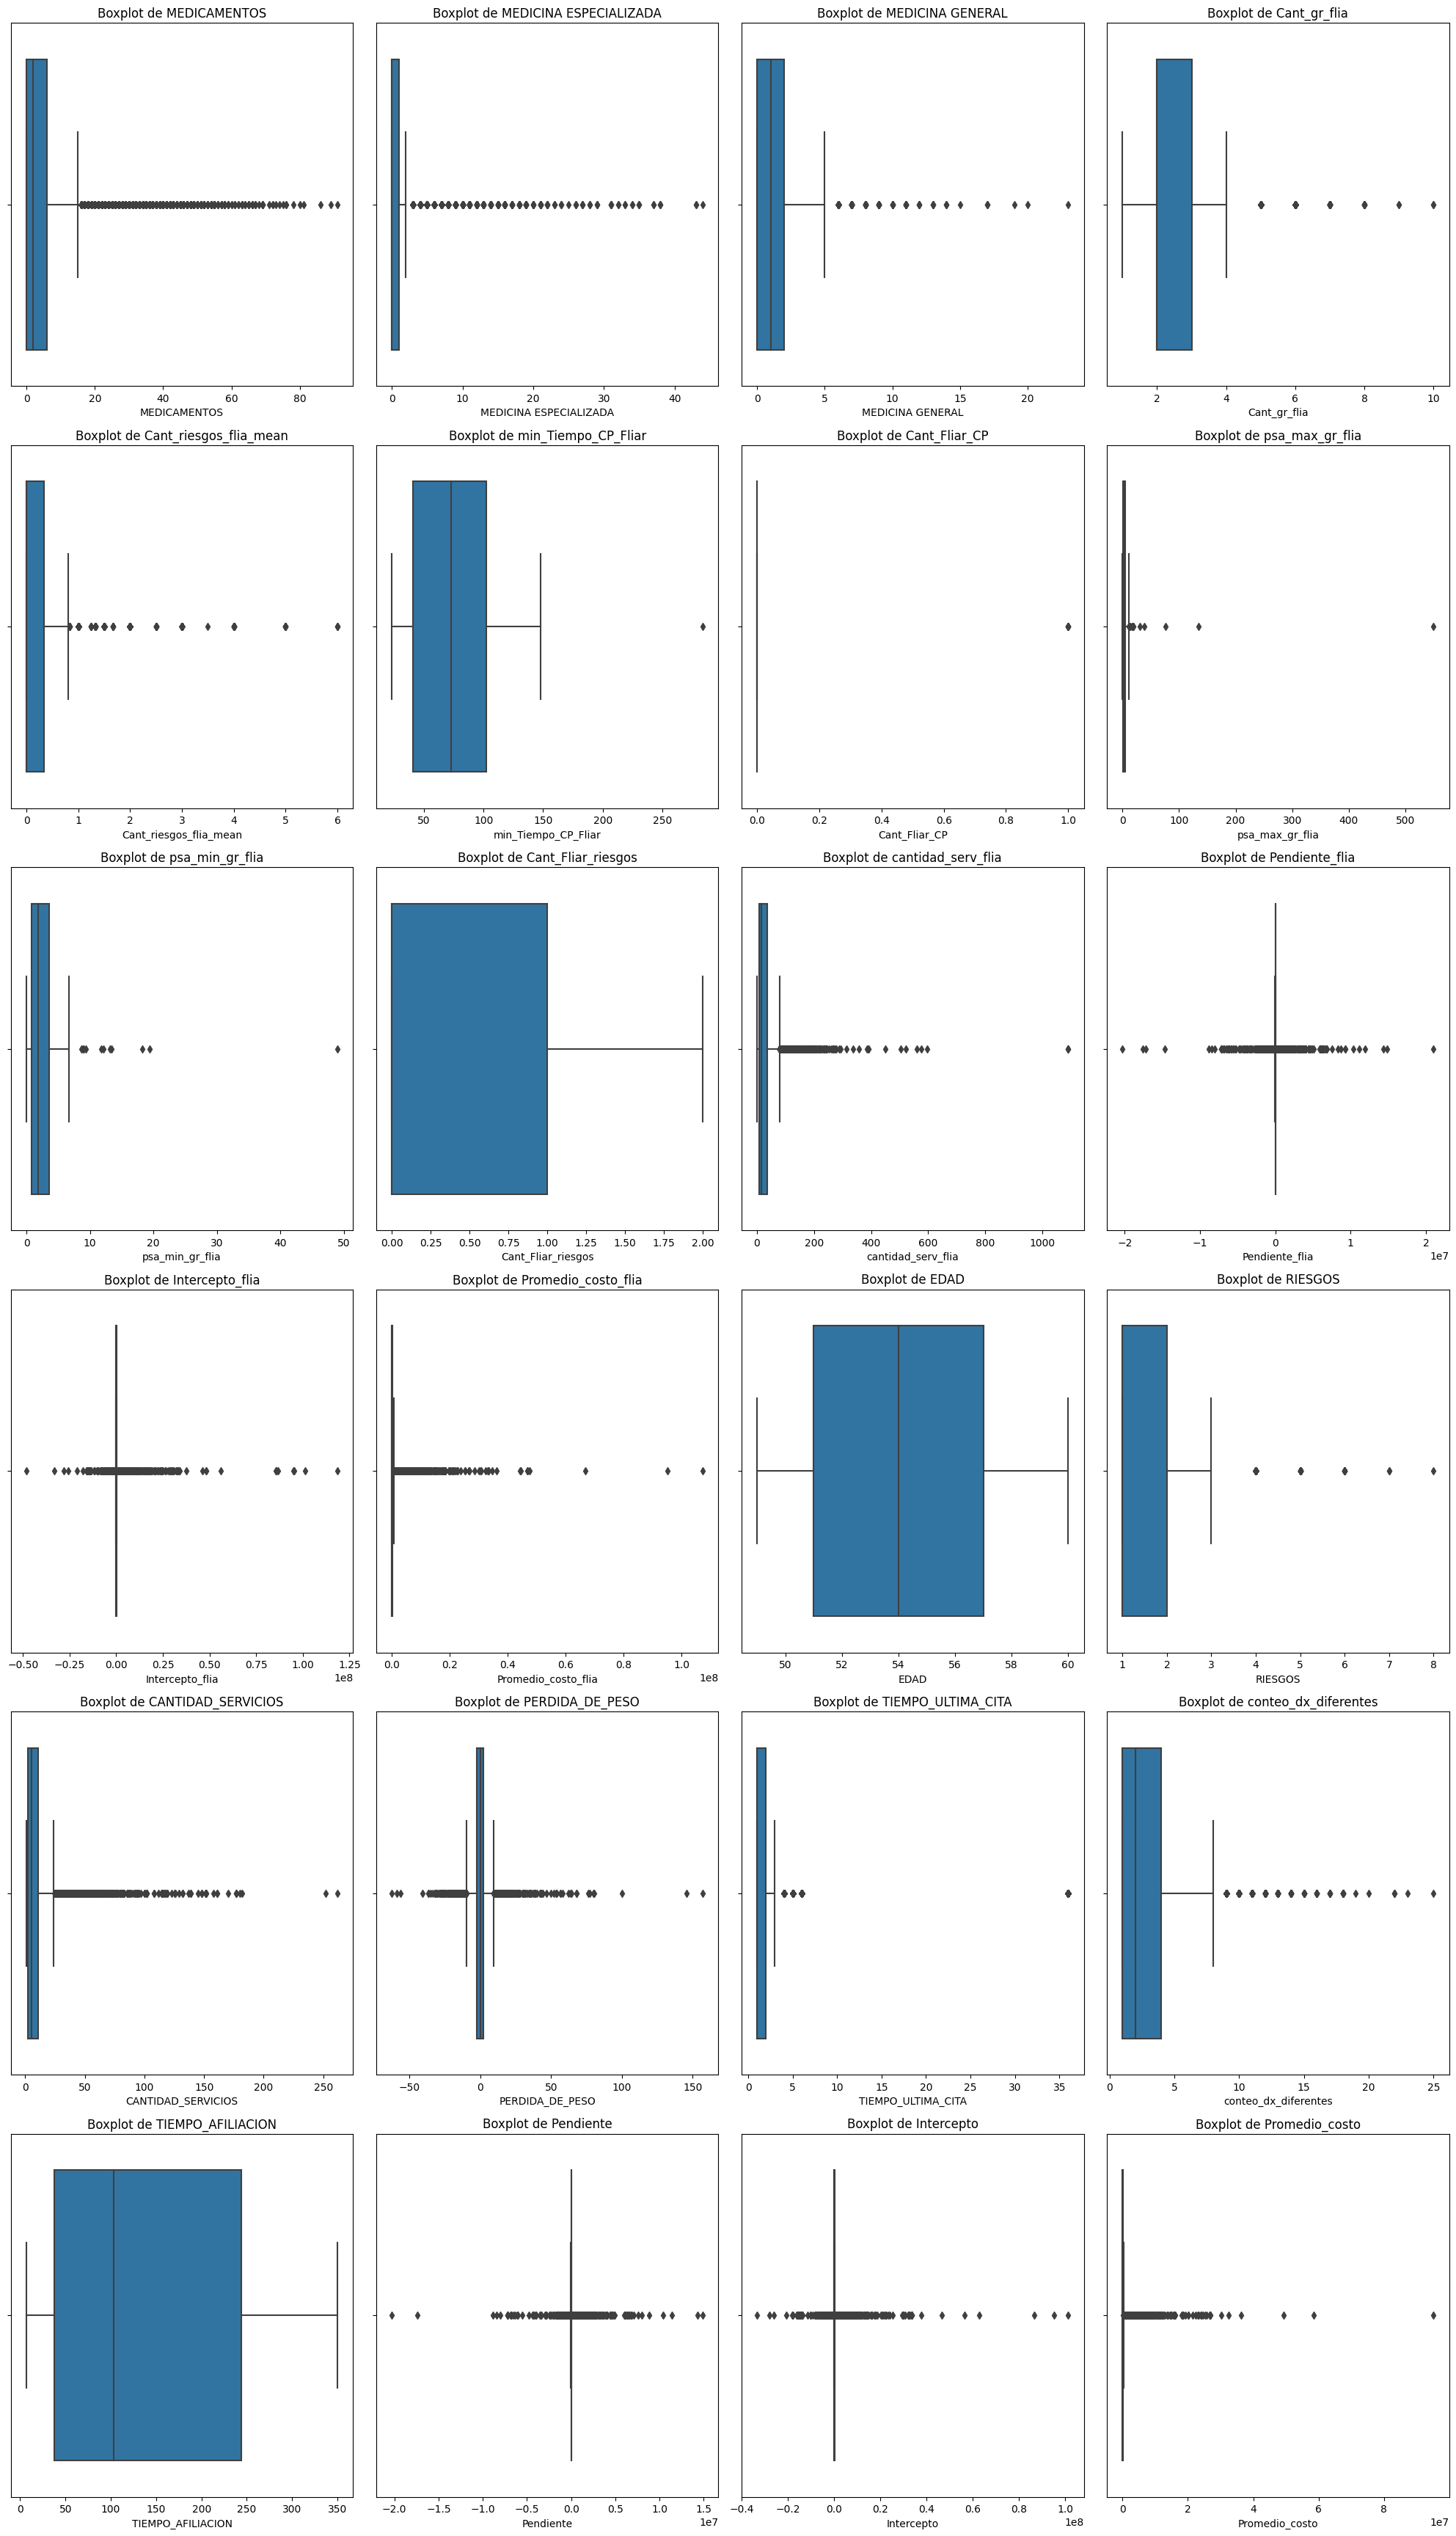

In [7]:
# Visualización de outliers usando boxplots por separado, para todas las columnas numéricas, dibujando 4 graficas por linea
num_columns = X.select_dtypes(include=[np.number]).columns.tolist()

plt.figure(figsize=(20, 40))
for i, col in enumerate(num_columns):
    plt.subplot(len(num_columns) // 4 + 1, 4, i + 1)
    sns.boxplot(x=X[col])
    plt.title(f'Boxplot de {col}')
plt.tight_layout()
plt.show()

Algunas variables muestran una gran cantidad de outliers, lo que podría indicar:

- 1.AGRUPACION_DIASTOLICA y AGRUPACION_SISTOLICA (Tensión Arterial):
Los valores atípicos en estas variables pueden representar mediciones de presión arterial anormalmente altas o bajas. Es probable que estos datos correspondan a pacientes con hipertensión o hipotensión no controlada.

- 2.Cant_Fliar_CP (Familiar con cáncer de próstata):
Dado que esta es una variable binaria o categórica (Sí/No), no debería presentar outliers, pero si el boxplot muestra valores extremos, podría ser por codificación incorrecta o errores en los datos.

- 3.Cant_gr_flia (Cantidad de personas en el grupo familiar):
Aquí los outliers pueden representar familias excepcionalmente grandes. Dependiendo del contexto del análisis, estos valores pueden ser importantes para identificar patrones relacionados con familias numerosas.

- 4.cantidad_serv_flia y CANTIDAD_SERVICIOS (Cantidad de servicios prestados):
Las observaciones atípicas en estas variables podrían reflejar familias o individuos que han utilizado un número significativamente mayor de servicios médicos en el último semestre.

- 5.conteo_dx_diferentes (Número de diagnósticos en el último semestre):
Los valores extremos aquí podrían estar asociados a pacientes con múltiples enfermedades crónicas o comorbilidades.

- 6.EDAD:
En esta variable, los valores atípicos probablemente se encuentren en los extremos del espectro, es decir, individuos muy jóvenes o muy mayores. Estos grupos podrían requerir un enfoque diferente en cuanto a tratamientos y prevención de enfermedades.

- 7.IMC (Índice de Masa Corporal):
Los valores extremadamente altos o bajos de IMC pueden indicar obesidad severa o desnutrición. Estos casos son críticos en el análisis de salud, ya que pueden estar asociados a otras condiciones como diabetes o enfermedades cardiovasculares.

- 8.Pendiente, Pendiente_flia, Intercepto, Intercepto_flia (Costos familiares y personales):
Estas variables muestran outliers que probablemente representan individuos o familias con costos de salud extremadamente altos. Estos podrían estar relacionados con enfermedades crónicas, tratamientos costosos o hospitalizaciones prolongadas.

- 9.Promedio_costo, Promedio_costo_flia:
Al igual que las variables anteriores de costos, los outliers en estas variables probablemente representan promedios excepcionalmente altos en los costos de atención médica de individuos o familias.

- 10.psa_max_gr_flia, psa_min_gr_flia (Resultados de PSA - Cáncer de Próstata):
Los outliers en estos datos pueden corresponder a resultados de PSA anormalmente altos o bajos en familiares de los usuarios, lo que podría indicar un riesgo elevado de cáncer de próstata.

- 11.PERDIDA_DE_PESO (Variación de peso en el último año):
Outliers: Valores atípicos en esta variable pueden reflejar cambios de peso significativos, lo que podría estar asociado a problemas de salud como desnutrición, caquexia (pérdida extrema de peso por enfermedades crónicas) o recuperación postoperatoria.

- 12.TIEMPO_AFILIACION y TIEMPO_ULTIMA_CITA:
Los valores extremos en estas variables pueden representar usuarios que han estado afiliados por mucho tiempo o que no han tenido una cita en mucho tiempo. Podrían ser indicadores de poca adherencia a los servicios de salud o de usuarios fieles al sistema.

### 1.3: Imputación de Valores Faltantes y Transformaciones

In [8]:
# Separar el conjunto de datos en características (X) y la variable objetivo (y)
X = data_df.drop('Target', axis=1)
y = data_df['Target']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#### 1.3.1: Imputación de Valores Faltantes

In [9]:
numerical = data_df.select_dtypes(include=np.number).columns.tolist()
numerical.remove('Target')

categorical = data_df.select_dtypes(exclude=np.number).columns.tolist()

categorical.remove('estrato')
ordinal = ['estrato']

In [10]:
ordinal

['estrato']

### 1.4: Transformaciones Adicionales con Pipelines

In [11]:

# Pipeline datos ordinales
ordinal_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OrdinalEncoder())
]),


#### 1.4.1: Normalización y Escalado

In [12]:
# Pipeline datos numéricos
numerical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

#### 1.4.2: Dummificación de Variables Categóricas

In [13]:
# Pipeline datos categoricos
categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(sparse_output=True, handle_unknown="ignore"))
])

# Pegado de los tres pipelines
preprocessing_pipeline = ColumnTransformer([
    ("nominal_preprocessor", categorical_pipeline, categorical),
    ("ordinal_preprocessor", ordinal_pipeline, ordinal),
    ("numerical_preprocessor", numerical_pipeline, numerical)
])

## 2: Feature Engineering y Optimización del Flujo de Trabajo

### 2.1: Transformaciones de Datos en el Pipeline

#### 2.2.1: Tratamiento de Variables Categóricas

#### 2.2.2: Reducción de Dimensionalidad

Aunque tanto PCA (Análisis de Componentes Principales) como LDA (Análisis Discriminante Lineal)  son técnicas de reducción de dimensionalidad, sus objetivos y aplicaciones son diferentes:

- PCA es no supervisado: Solo busca la proyección que maximiza la varianza general en los datos, sin tener en cuenta las clases.

- LDA es supervisado: Usa la información de las etiquetas de clase para encontrar la proyección que maximiza la separación entre clases.

Por lo tanto trabajaremos con LDA

#### 2.2.3: Selección de Variables Relevantes

### 2.2: Construcción de Pipelines Complejos para el Modelado

#### 2.2.1: Construcción de un Pipeline Completo

In [14]:
class ModelOptimization:
  def __init__(self, df, num_features, ord_features, cat_features):
    self.df = df.copy()
    self.df = pd.DataFrame(self.df)
    self.num_features = num_features  # Variables numéricas
    self.ord_features = ord_features
    self.cat_features = cat_features  # Variables categóricas
   
    # Separar el conjunto de datos en características (X) y la variable objetivo (y)
    X = self.df.drop('Target', axis=1)
    y = self.df['Target']

    # Dividir los datos en conjuntos de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
   
    # Eliminar la columna 'Target' de las variables numéricas si está presente
    if 'Target' in self.num_features:
            self.num_features.remove('Target')
        
## Ejecutar modelo SVC (Support Vector Classifier)      
  def run_svc(self,num_strategy, scaler_type, 
              ord_strategy, ord_handle_unk, 
              nom_strategy, sparse_output, nom_handle_unk,
              C, kernel, gamma):
    
    # Datos Numericos
    if scaler_type == "StandardScaler":
        num_scaler = StandardScaler()
    elif scaler_type == "MinMaxScaler":
        num_scaler = MinMaxScaler()
    elif scaler_type == "RobustScaler":
        num_scaler = RobustScaler()
          
    if num_strategy == "constant":
        num_fval = -1
        num_imputer = SimpleImputer(strategy=num_strategy, fill_value=num_fval)
    else:
        num_fval = None
        num_imputer = SimpleImputer(strategy=num_strategy)   
        
    # Pipeline datos numéricos
    numerical_pipeline = Pipeline([
        ("imputer", num_imputer),
        ("scaler",  num_scaler)
    ])
    
    
    
    # Pipeline datos ordinales
    if ord_strategy == "constant":
        ord_fval = -1 #trial.suggest_int("fill_value", -1000, 1000)
        ord_imputer = SimpleImputer(strategy=ord_strategy, fill_value=ord_fval)
    else:
        ord_fval = None
        ord_imputer = SimpleImputer(strategy=ord_strategy)   

    # Si se selecciona 'use_encoded_value', sugerir un valor para las categorías desconocidas
    if ord_handle_unk == "use_encoded_value":
        unknown_value = -1 #trial.suggest_int("unknown_value", -1000, 1000)
    else:
        unknown_value = None

    ord_encoder = OrdinalEncoder(handle_unknown=ord_handle_unk, unknown_value=unknown_value)

    ordinal_pipeline = Pipeline([
        ("imputer", ord_imputer),
        ("encoder", ord_encoder)
    ])
    
    
#####################################################################################
    # Datos No-Numericos

    # Si se selecciona 'constant', sugerir el valor para imputar
    if nom_strategy == "constant":
        nom_fval = -1 #trial.suggest_int("fill_value", -1000, 1000)
        nom_imputer = SimpleImputer(strategy=nom_strategy, fill_value=nom_fval)
    else:
        nom_fval = None
        nom_imputer = SimpleImputer(strategy=nom_strategy)
    
    # Seleccionar si el OneHotEncoder debe devolver una matriz dispersa o densa
    nom_encoder = OneHotEncoder(sparse_output=sparse_output, handle_unknown=nom_handle_unk)

    nominal_pipeline = Pipeline([
        ("imputer", nom_imputer),
        ("encoder", nom_encoder)
    ])


# Pegado de los tres pipelines
    preprocessing_pipeline = ColumnTransformer([
        ("numerical_preprocessor", numerical_pipeline, self.num_features),
        ("ordinal_preprocessor", ordinal_pipeline, self.ord_features),
        ("nominal_preprocessor", nominal_pipeline, self.cat_features)
    ])
    
    if kernel in ["rbf", "poly", "sigmoid"]:
        lv_gamma = gamma
    else:
        lv_gamma = "scale"  # Si es lineal, gamma no aplica

    
    # Crear el modelo SVC
    model = Pipeline([
        ("preprocessor", preprocessing_pipeline),
        ("classifier", SVC(C=C, kernel=kernel, gamma=lv_gamma, random_state=42))
    ])

    
    # Evaluar el modelo utilizando validación cruzada
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="accuracy")

    # Devolver la media de la precisión como objetivo a maximizar
    return scores.mean()

  def objective_svc(self, trial):
    num_strategy    = trial.suggest_categorical('num_strategy', ['mean', 'median', 'most_frequent', 'constant'])
    num_fval        = trial.suggest_int("fill_value", -1000, 1000)
    scaler_type     = trial.suggest_categorical('scaler', ['StandardScaler', 'MinMaxScaler', 'RobustScaler'])
####    
    ord_strategy    = trial.suggest_categorical('ord_strategy', ['most_frequent', 'constant'])
    ord_handle_unk  = trial.suggest_categorical('ord_handle_unknown', ['error', 'use_encoded_value'])
####
    nom_strategy    = trial.suggest_categorical('nom_strategy', ['most_frequent', 'constant'])
    sparse_output   = trial.suggest_categorical("sparse_output", [True, False])
    nom_handle_unk  = trial.suggest_categorical('nom_handle_unknown', ["ignore", "error"])

### Hiperparámetros del modelo SVC
    C               = trial.suggest_float("svc_C", 0.1, 10.0)
    kernel          = trial.suggest_categorical("svc_kernel", ["linear", "rbf", "poly", "sigmoid"])
    gamma           = trial.suggest_float("svc_gamma", 0.001, 1.0)

    model = self.run_svc(num_strategy=num_strategy, scaler_type=scaler_type,
                         ord_strategy=ord_strategy, ord_handle_unk=ord_handle_unk,
                         nom_strategy=nom_strategy, sparse_output=sparse_output,nom_handle_unk=nom_handle_unk,
                         C=C, kernel=kernel, gamma=gamma) 

    
    return model



In [15]:
num_features = data_df.select_dtypes(exclude=['object']).columns.tolist()  # Variables numéricas
ord_features = ['estrato']
cat_features = data_df.select_dtypes(include=['object']).columns.tolist()  # Variables categóricas
cat_features.remove('estrato')

In [16]:
X = 1/0

ZeroDivisionError: division by zero

In [17]:
trials        = 1
model_optimization = ModelOptimization(data_df, num_features, ord_features, cat_features)

study_svc = optuna.create_study(direction='minimize')
study_svc.optimize(model_optimization.objective_svc, n_trials=trials)
'''
results.append({
'producto': producto,
'tipo': 'Promedio movil',
'rmse': study_pm.best_value,
'best_params': study_pm.best_params })'''

[I 2024-09-27 20:28:14,048] A new study created in memory with name: no-name-cc311528-c909-44d9-996b-4c4382e3aef8
[W 2024-09-27 20:37:14,554] Trial 0 failed with parameters: {'num_strategy': 'mean', 'fill_value': -344, 'scaler': 'StandardScaler', 'ord_strategy': 'most_frequent', 'ord_handle_unknown': 'error', 'nom_strategy': 'constant', 'sparse_output': False, 'nom_handle_unknown': 'error', 'svc_C': 9.574913249880565, 'svc_kernel': 'linear', 'svc_gamma': 0.16833542074231264} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "C:\Users\apont\AppData\Roaming\Python\Python311\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\apont\AppData\Local\Temp\ipykernel_13612\4020912088.py", line 134, in objective_svc
    model = self.run_svc(num_strategy=num_strategy, scaler_type=scaler_type,
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

KeyboardInterrupt: 